In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
data = pd.read_csv('AMZN.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [3]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
torch.cuda.is_available()

False

In [6]:
data.loc[:,'Date'] = pd.to_datetime(data['Date'])

In [7]:
data['Date'].isna().sum()

0

In [8]:
data = data.dropna(subset=['Date'])

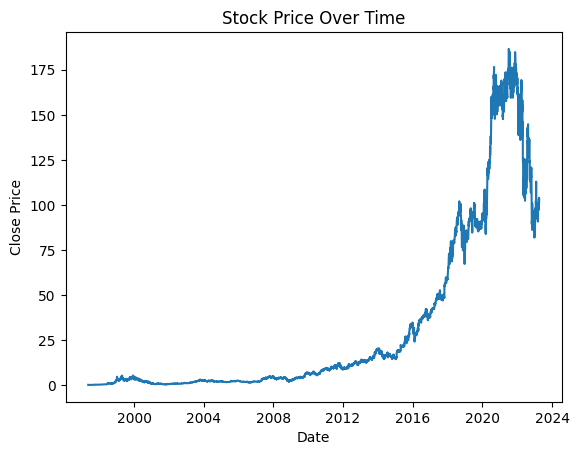

In [9]:
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Over Time')

plt.plot(data['Date'], data['Close'])

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

data_scaled = data.copy()
data_scaled['Close'] = scaler.fit_transform(data[['Close']])

In [11]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, window):
    df = dc(df)
    df.set_index('Date', inplace=True)

    for i in range(1, window+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

In [12]:
data_for_lstm = prepare_dataframe_for_lstm(data_scaled, 7)
data_for_lstm

C:\Users\noure\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,-0.999899,-0.999944,-1.000000,-0.999983,-0.999872,-0.999832,-0.999821,-0.999698
1997-05-28,-0.999927,-0.999899,-0.999944,-1.000000,-0.999983,-0.999872,-0.999832,-0.999821
1997-05-29,-0.999941,-0.999927,-0.999899,-0.999944,-1.000000,-0.999983,-0.999872,-0.999832
1997-05-30,-0.999944,-0.999941,-0.999927,-0.999899,-0.999944,-1.000000,-0.999983,-0.999872
1997-06-02,-0.999939,-0.999944,-0.999941,-0.999927,-0.999899,-0.999944,-1.000000,-0.999983
...,...,...,...,...,...,...,...,...
2023-03-30,0.093081,0.074315,0.042036,0.050615,0.051580,0.057800,0.057693,0.078175
2023-03-31,0.106915,0.093081,0.074315,0.042036,0.050615,0.051580,0.057800,0.057693
2023-04-03,0.097478,0.106915,0.093081,0.074315,0.042036,0.050615,0.051580,0.057800


In [13]:
X = data_for_lstm.iloc[:, 1:]
y = data_for_lstm.iloc[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

In [14]:
# Close(t-1), Close(t-2), ... Close(t-7) => Close(t-7), Close(t-6), ... Close(t-1)
X = dc(np.flip(X.values, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99994415],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99989946],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99992739],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10691495],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747802],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11399263]])

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.05)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [17]:
X_train = torch.tensor(X_train).view(-1, 7, 1).float()
y_train = torch.tensor(y_train).view(-1, 1).float()
X_test = torch.tensor(X_test).view(-1, 7, 1).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

C:\Users\noure\AppData\Local\Temp\ipykernel_22764\2064599454.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = torch.tensor(y_train).view(-1, 1).float()
C:\Users\noure\AppData\Local\Temp\ipykernel_22764\2064599454.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = torch.tensor(y_test).view(-1, 1).float()


(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [18]:
class StockForecastingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [19]:
train_dataset = StockForecastingDataset(X_train, y_train)
test_dataset = StockForecastingDataset(X_test, y_test)

#### DataLoaders:
##### 1. They make it easy to access the data in batches.
##### 2. They make it easy to shuffle the data each epoch.
##### 3. They makes it easy to iterate over datasets during training and evaluation.

In [20]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [21]:
class OWN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        # number of features
        self.input_size = input_size
        # number of outputs of LSTM
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # batch_first=True ensures that input tensors have shape
        # (batch_size, sequence_length, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape is (batch_size, sequence_length, input_size) 
        batch_size = x.size(0)
        # cell state at time zero (long-term memory)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        # hidden state at time zero (short-term memory)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # out: contains the hidden state output for every time step in the sequence
        # hn: Represents the hidden state of the last time step for each layer
        # cn: Represents the cell state of the last time step for each layer
        out, (hn, cn)= self.lstm(x, (h0, c0))
        # This selects the hidden state of the last time step in the sequence
        out = self.fc(out[:, -1, :])

        return out
        

In [22]:
model = OWN_LSTM(1, 16, 1)
model.to(device)

model

OWN_LSTM(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [23]:
# Loss function for regression
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
num_epochs = 10

for epoch in range(10):
    # Training step
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass, loss calculation, backward pass
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)  # Average loss per epoch

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)  # Average loss per epoch

    # Print the loss for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch [1/10], Train Loss: 0.0027, Validation Loss: 0.0015
Epoch [2/10], Train Loss: 0.0010, Validation Loss: 0.0006
Epoch [3/10], Train Loss: 0.0005, Validation Loss: 0.0004
Epoch [4/10], Train Loss: 0.0005, Validation Loss: 0.0004
Epoch [5/10], Train Loss: 0.0004, Validation Loss: 0.0003
Epoch [6/10], Train Loss: 0.0004, Validation Loss: 0.0003
Epoch [7/10], Train Loss: 0.0004, Validation Loss: 0.0003
Epoch [8/10], Train Loss: 0.0004, Validation Loss: 0.0003
Epoch [9/10], Train Loss: 0.0004, Validation Loss: 0.0003
Epoch [10/10], Train Loss: 0.0004, Validation Loss: 0.0003


In [ ]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test[:200], label='Actual Close')
plt.plot(predicted[:200], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()